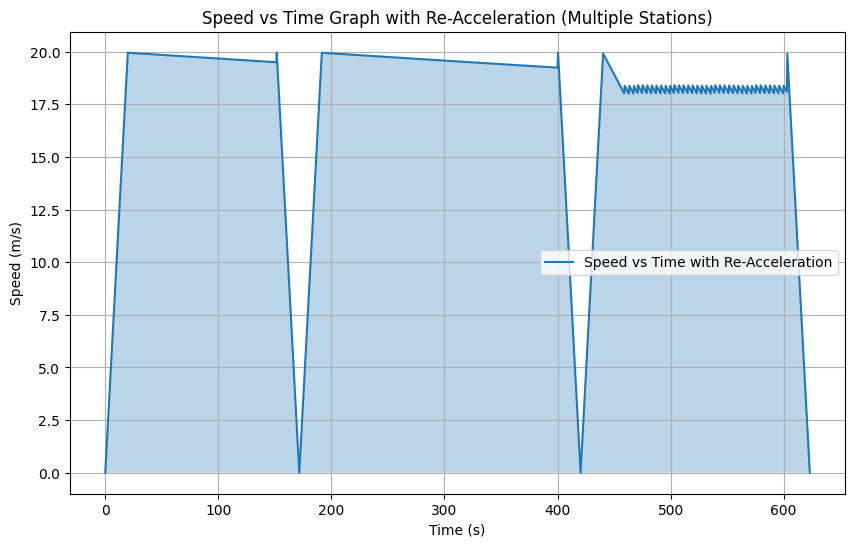

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Train resistance equation coefficients (example values)
A = 100  # N (constant resistance)
B = 10   # N/(m/s) (linear term)
C = 1    # N/(m/s)^2 (quadratic term)

# Mass of the train in kg
mass_train = 200000  # 200 tons (200,000 kg)

# Function to calculate train resistance at a given velocity (normal + additional resistances)
def train_resistance(v, curve_resistance=0, gradient_resistance=0):
    return A + B * v + C * v**2 + curve_resistance + gradient_resistance

# Function to calculate coasting deceleration at a given speed
def coasting_deceleration(v, curve_resistance=0, gradient_resistance=0):
    F_r = train_resistance(v, curve_resistance, gradient_resistance)
    return -F_r / mass_train  # Deceleration is negative since it opposes motion

# Function to calculate average speed with coasting and re-acceleration phase for a segment
def calculate_average_speed_with_reacceleration(d, a, b, m, curve_resistance=0, gradient_resistance=0):
    # Time to accelerate and brake
    t_accel = m / a
    t_brake = m / b

    # Distance covered during acceleration and braking phases
    d_accel = 0.5 * a * t_accel**2
    d_brake = 0.5 * b * t_brake**2

    # Check if the train reaches max speed
    if d_accel + d_brake > d:
        # The train never reaches max speed
        t_total = np.sqrt(2 * d / (a + b))
        avg_speed = d / t_total
        return avg_speed, t_total, t_total / 2  # avg_speed, total_time, time to reach max speed
    else:
        # Distance to cover during coasting
        d_coast = d - (d_accel + d_brake)
        v = m  # starting speed for coasting
        dt = 0.1  # time step
        t_coast = 0

        # Threshold for speed to trigger re-acceleration
        speed_threshold = 0.9 * m
        reacceleration_times = 0

        while v > 0 and d_coast > 0:
            decel = coasting_deceleration(v, curve_resistance, gradient_resistance)
            v = max(0, v + decel * dt)  # Update velocity based on deceleration
            d_coast -= v * dt  # Update distance covered during this time step
            t_coast += dt

            # Check if speed falls below 90% of max speed and trigger re-acceleration
            if v < speed_threshold and d_coast > 0:
                while v < m and d_coast > 0:
                    v += a * dt  # Accelerate back to max speed
                    d_coast -= v * dt
                    t_coast += dt
                reacceleration_times += 1

        # Total time
        t_total = t_accel + t_coast + t_brake
        avg_speed = d / t_total
        return avg_speed, t_total, t_accel, t_coast, t_brake, reacceleration_times

# Function to plot speed vs time for multiple stations
def plot_speed_vs_time_with_reacceleration(distances, a, b, m, curve_resistances, gradient_resistances):
    total_time = 0
    time_points = []
    speed_points = []

    for idx, d in enumerate(distances):
        curve_res = curve_resistances[idx] if idx < len(curve_resistances) else 0
        gradient_res = gradient_resistances[idx] if idx < len(gradient_resistances) else 0
        
        avg_speed, segment_time, t_accel, t_coast, t_brake, reaccel_times = calculate_average_speed_with_reacceleration(d, a, b, m, curve_res, gradient_res)
        time_points_segment = np.linspace(total_time, total_time + segment_time, 500)
        speed_points_segment = np.zeros_like(time_points_segment)

        for i in range(len(time_points_segment)):
            t = time_points_segment[i] - total_time
            if t < t_accel:
                speed_points_segment[i] = a * t
            elif t < t_accel + t_coast:
                v_prev = speed_points_segment[i-1] if i > 0 else m
                decel = coasting_deceleration(v_prev, curve_res, gradient_res)
                speed_points_segment[i] = max(0, v_prev + decel * (time_points_segment[i] - time_points_segment[i-1]))
                if speed_points_segment[i] < 0.9 * m:
                    # Re-accelerate when speed drops below 90% of max speed
                    speed_points_segment[i] += a * (time_points_segment[i] - time_points_segment[i-1])
            else:
                time_since_brake = t - t_accel - t_coast
                speed_points_segment[i] = max(0, m - b * time_since_brake)

        # Append time and speed points
        time_points.extend(time_points_segment)
        speed_points.extend(speed_points_segment)
        total_time += segment_time

    # Plot the graph
    plt.figure(figsize=(10, 6))
    plt.plot(time_points, speed_points, label='Speed vs Time with Re-Acceleration')
    plt.fill_between(time_points, 0, speed_points, alpha=0.3)
    plt.title("Speed vs Time Graph with Re-Acceleration (Multiple Stations)")
    plt.xlabel("Time (s)")
    plt.ylabel("Speed (m/s)")
    plt.grid(True)
    plt.legend()
    plt.show()

# Inter-station distances (in meters)
distances = [3000, 4500, 3500]  # A -> B, B -> C, C -> D

# Curve and gradient resistances for each segment
curve_resistances = [600 / 200, 0, 0]  # Example: 1 in 200 curve between A -> B
gradient_resistances = [0, 0, 9.81 * 1 / 100 * mass_train]  # Example: 1 in 100 gradient between C -> D

# Parameters (example values)
a = 1.0  # acceleration in m/s^2
b = 1.0  # braking rate in m/s^2
m = 20.0  # maximum speed in m/s

# Plot speed vs time for multiple stations with re-acceleration logic
plot_speed_vs_time_with_reacceleration(distances, a, b, m, curve_resistances, gradient_resistances)
